# Data Exploration

In [93]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [94]:
predictors = pd.read_csv('../data/water_table_training.csv')
target = pd.read_csv('../data/water_table_labels.csv')

df = predictors.merge(target, on = 'id')

In [95]:
##selecting which columns to drop based off impact on prediction and overlapping information
columns = ['id', 'date_recorded', 'installer', 'wpt_name', 'num_private', 'region', 'subvillage', 
           'ward', 'recorded_by', 'scheme_name', 'extraction_type_group', 'payment', 'water_quality', 
           'quantity', 'source_type', 'waterpoint_type_group', 'public_meeting']

In [96]:
cleaned_df = df.drop(columns = columns, axis = 1)
cleaned_df.dropna(inplace = True)

count    51329.000000
mean      1334.765552
std        940.138379
min          0.000000
25%          0.000000
50%       1987.000000
75%       2005.000000
max       2013.000000
Name: construction_year, dtype: float64 
Mode: 0    2008.0
dtype: float64


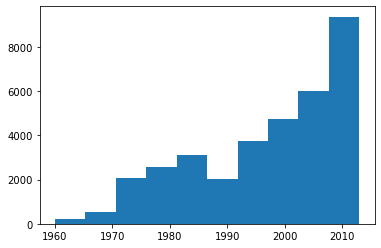

In [97]:
##checking to see distribution of non-zero(np.nan) values to determine how to impute
## will impute with mode

print(cleaned_df.construction_year.describe(), '\nMode:', cleaned_df.construction_year.replace(0.0, np.nan).mode())
plt.hist(cleaned_df.construction_year.replace(0.0, np.nan));

In [98]:
#replacing string values for status group with 0, 1, or 1 in 'status_no'
#0 target is functional, 1 target is non or needs repair (positive class for predicting)

conditions = [cleaned_df['status_group'] == 'functional', cleaned_df['status_group'] == 'functional needs repair', cleaned_df['status_group'] == 'non functional']
choices = [0, 1, 1]

cleaned_df['status_no'] = np.select(conditions, choices)
cleaned_df.drop('status_group', axis = 1, inplace = True)


In [101]:
len(cleaned_df[cleaned_df['status_no'] == 1]) #number of non-functional or needs repairs 

23253

In [7]:
##Separating predictor feature columns into categorical and continuous value groups
#continuous features
numerical_columns = ['amount_tsh', 'gps_height', 'longitude', 'latitude', 'population', 'construction_year']
#categorical features without the target of 'status_group'
categorical_columns = cleaned_df.select_dtypes(include = 'object').columns


##Smaller amount of features to reduce computational strain - using all categoricals turned into 1600+ columns
final_columns_list = ['amount_tsh', 'longitude', 'latitude', 'construction_year', 'region_code', 'scheme_management', 'quality_group', 'quantity_group', 'source', 'extraction_type_class', 'waterpoint_type']

numericals = ['amount_tsh', 'longitude', 'latitude', 'construction_year']
categoricals = ['region_code', 'scheme_management', 'quality_group', 'quantity_group', 'source', 'extraction_type_class', 'waterpoint_type']


In [118]:
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, GridSearchCV, RandomizedSearchCV
from sklearn.impute import MissingIndicator, SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PowerTransformer
from sklearn.metrics import plot_confusion_matrix, precision_score, recall_score, accuracy_score, f1_score, roc_curve, auc
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.ensemble import RandomForestClassifier

from xgboost import XGBClassifier

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline, make_pipeline

X = cleaned_df[final_columns_list]
y = cleaned_df['status_no']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2, stratify = y, random_state = 42)

### Transformation on the Train Set

In [9]:
class CustomTransformer(BaseEstimator, TransformerMixin):
    
    def __init__(self):
        
        self.column_trans = None
    
    def fit(self, X_t, y_t = None):
        X_ = X_t.copy()
        column_transformer = ColumnTransformer(transformers = [('imputer', SimpleImputer(missing_values = 0.0, strategy = 'most_frequent'), ['construction_year']),                     
                                                      ('ohe', OneHotEncoder(sparse = False, handle_unknown = 'ignore'), categoricals)],
 
                                                      n_jobs = -1)
        column_transformer = column_transformer.fit(X_)
        self.column_trans = column_transformer
        return column_transformer
    
    def transform(self, X, y = None):

        X_ = self.column_trans.transform(X)
        return X_
        

In [10]:
logreg_pipe = Pipeline(steps =[('transform', CustomTransformer()),('scaler', StandardScaler()),('logreg', LogisticRegression())])
bernoulli_pipe = Pipeline(steps =[('transform', CustomTransformer()),('scaler', StandardScaler()),('bern', BernoulliNB())])
knn_pipe = Pipeline(steps =[('transform', CustomTransformer()),('scaler', StandardScaler()),('knn', KNeighborsClassifier())])
tree_pipe = Pipeline(steps =[('transform', CustomTransformer()),('scaler', StandardScaler()),('tree', DecisionTreeClassifier())])
forest_pipe = Pipeline(steps =[('transform', CustomTransformer()),('scaler', StandardScaler()),('forest', RandomForestClassifier())])
xgb_pipe = Pipeline(steps =[('transform', CustomTransformer()),('scaler', StandardScaler()),('xgb', XGBClassifier())])


### GridSearchCV parameters

In [86]:
logreg_params = {
   'logreg__C':[.1, .75],
   'logreg__max_iter':[500],
   'logreg__solver':['lbfgs', 'liblinear']
            }
                       
bernoulli_params = {'bern__alpha': list(np.linspace(.1, 1, 10))}

knn_params = {
    'knn__n_neighbors': [3, 7, 12], 
    'knn__weights':['uniform', 'distance'], 
    'knn__p':[1, 3, 5] 
             }

tree_params = {
    'tree__criterion':['gini', 'entropy'],  
    'tree__max_depth': [10, 25, 40, 55],
    'tree__min_samples_leaf':[1, 2, 3], 
    'tree__max_features': ['auto', 'sqrt']
              } 
forest_params = {
    'forest__n_estimators':[100, 125],
    'forest__criterion':['gini', 'entropy'],
    'forest__max_depth':[20, 40, None],
    'forest__min_samples_leaf':[1, 2, 3], 
    'forest__max_features': ['auto','sqrt', 'log2']
                }

xgb_params = {
    'xgb__eta':[.9],
    'xgb__min_child_weight': [1.5], 
    'xgb__max_depth':[7], 
    'xgb__subsample':[.8], 
    'xgb__reg_lambda':[1.0, 1.5, 2.0], 
    'xgb__reg_alpha': [0.0, .5, 1.0]
             } 

### Logistic Regression

In [13]:
log_grid = GridSearchCV(estimator = logreg_pipe, param_grid = logreg_params, scoring = 'recall')

In [14]:
log_grid.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('transform', CustomTransformer()),
                                       ('scaler', StandardScaler()),
                                       ('logreg', LogisticRegression())]),
             param_grid={'logreg__C': [0.1, 0.75], 'logreg__max_iter': [500],
                         'logreg__solver': ['lbfgs', 'liblinear']},
             scoring='recall')

In [15]:
log_grid.best_params_

{'logreg__C': 0.75, 'logreg__max_iter': 500, 'logreg__solver': 'lbfgs'}

### Bernoulli

In [14]:
bern_grid = GridSearchCV(estimator = bernoulli_pipe, param_grid = bernoulli_params, scoring = 'recall')

In [20]:
bern_grid.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('transform', CustomTransformer()),
                                       ('scaler', StandardScaler()),
                                       ('bern', BernoulliNB())]),
             param_grid={'bern__alpha': [0.1, 0.2, 0.30000000000000004, 0.4,
                                         0.5, 0.6, 0.7000000000000001, 0.8, 0.9,
                                         1.0]},
             scoring='recall')

In [21]:
bern_grid.best_params_

{'bern__alpha': 0.1}

### K Nearest Neighbors

In [15]:
knn_grid = GridSearchCV(estimator = knn_pipe, param_grid = knn_params, scoring = 'recall')

In [ ]:
knn_grid.fit(X_train, y_train)

### Decision Tree

In [16]:
tree_grid = GridSearchCV(estimator = tree_pipe, param_grid = tree_params, scoring = 'recall')

In [14]:
tree_grid.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('transform', CustomTransformer()),
                                       ('scaler', StandardScaler()),
                                       ('tree', DecisionTreeClassifier())]),
             param_grid={'tree__criterion': ['gini', 'entropy'],
                         'tree__max_depth': [10, 25, 40, 55],
                         'tree__max_features': ['auto', 'sqrt'],
                         'tree__min_samples_leaf': [1, 2, 3]},
             scoring='recall')

In [15]:
tree_grid.best_params_

{'tree__criterion': 'entropy',
 'tree__max_depth': 55,
 'tree__max_features': 'sqrt',
 'tree__min_samples_leaf': 1}

### RandomSearchCV on Random Forest

In [87]:
rs_forest = RandomizedSearchCV(estimator = forest_pipe,
                        param_distributions = forest_params,
                        n_iter = 10,                      
                        random_state=42)

rs_forest.fit(X_train, y_train)

RandomizedSearchCV(estimator=Pipeline(steps=[('transform', CustomTransformer()),
                                             ('scaler', StandardScaler()),
                                             ('forest',
                                              RandomForestClassifier())]),
                   param_distributions={'forest__criterion': ['gini',
                                                              'entropy'],
                                        'forest__max_depth': [20, 40, None],
                                        'forest__max_features': ['auto', 'sqrt',
                                                                 'log2'],
                                        'forest__min_samples_leaf': [1, 2, 3],
                                        'forest__n_estimators': [100, 125]},
                   random_state=42)

In [89]:
rs_forest.best_params_

{'forest__n_estimators': 125,
 'forest__min_samples_leaf': 2,
 'forest__max_features': 'sqrt',
 'forest__max_depth': None,
 'forest__criterion': 'gini'}

## XGBoost

These are really computationally expensive, so we are trying one set of params at a time by commenting out each other set of parameters at a time and finding the best one to see if the sum of parts works.

In [67]:
xgb_grid = GridSearchCV(estimator = xgb_pipe, param_grid = xgb_params, scoring = 'recall')

In [68]:
xgb_grid.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('transform', CustomTransformer()),
                                       ('scaler', StandardScaler()),
                                       ('xgb',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=None,
                                                      gamma=None, gpu_id=None,
                                                      importance_type='gain',
                                                      interaction_constraints=None,
                                                      learning_rate=None,
                                                      max_delta_step=None,
                                                

### RandomSearch on XGB

In [81]:
xgb_random = {
        'xgb__eta':[.7, .9, 1.1],
        'xgb__max_depth': [6, 10, 15, 20],
        'xgb__learning_rate': [0.001, 0.01, 0.1, 0.2, 0,3],
        'xgb__subsample': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
        'xgb__colsample_bytree': [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
        'xgb__colsample_bylevel': [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
        'xgb__min_child_weight': [0.5, 1.0, 3.0, 5.0, 7.0, 10.0],
        'xgb__gamma': [0, 0.25, 0.5, 1.0],
        'xgb__reg_lambda': [0.1, 1.0, 5.0, 10.0, 50.0, 100.0],
        'xgb__n_estimators': [100, 120]}

In [83]:
rs = RandomizedSearchCV(estimator = xgb_pipe,
                        param_distributions = xgb_random,
                        n_iter = 10,                      
                        random_state=42)

rs.fit(X_train, y_train)

RandomizedSearchCV(estimator=Pipeline(steps=[('transform', CustomTransformer()),
                                             ('scaler', StandardScaler()),
                                             ('xgb',
                                              XGBClassifier(base_score=None,
                                                            booster=None,
                                                            colsample_bylevel=None,
                                                            colsample_bynode=None,
                                                            colsample_bytree=None,
                                                            gamma=None,
                                                            gpu_id=None,
                                                            importance_type='gain',
                                                            interaction_constraints=None,
                                                            learning_ra

In [90]:
rs.best_params_, rs.best_score_

({'xgb__subsample': 0.9,
  'xgb__reg_lambda': 1.0,
  'xgb__n_estimators': 120,
  'xgb__min_child_weight': 1.0,
  'xgb__max_depth': 15,
  'xgb__learning_rate': 0.1,
  'xgb__gamma': 1.0,
  'xgb__eta': 0.9,
  'xgb__colsample_bytree': 0.9,
  'xgb__colsample_bylevel': 0.5},
 0.7911744499486368)

# Vanilla Models

## First Model with Cleaned Data - Logistic Regression

In [16]:
logreg_pipe.fit(X_train, y_train)

Pipeline(steps=[('transform', CustomTransformer()),
                ('scaler', StandardScaler()), ('power', PowerTransformer()),
                ('logreg', LogisticRegression())])

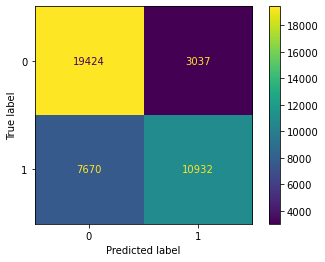

In [17]:
plot_confusion_matrix(logreg_pipe, X_train, y_train)

In [18]:
print("Score:", logreg_pipe.score(X_train, y_train))

Score: 0.7392543165380026


In [19]:
recall_score(y_train, logreg_pipe.predict(X_train))

0.5876787442210515

## Second Model - K Nearest Neighbors

In [20]:
knn_pipe.fit(X_train, y_train)

Pipeline(steps=[('transform', CustomTransformer()),
                ('scaler', StandardScaler()), ('knn', KNeighborsClassifier())])

In [ ]:
knn_pipe.score(X_train, y_train)

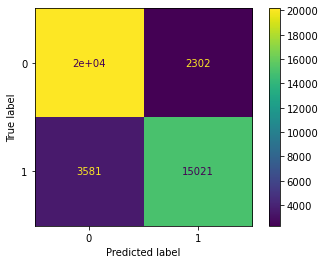

In [22]:
plot_confusion_matrix(knn_pipe, X_train, y_train)

## Third Model - Decision Tree Classifier

In [20]:
tree_pipe.fit(X_train, y_train)
tree_pipe.score(X_train, y_train)

0.8463336823904731

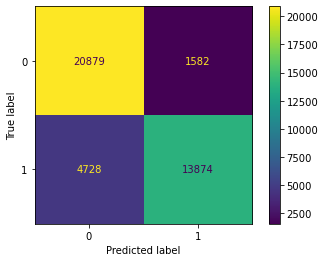

In [21]:
plot_confusion_matrix(tree_pipe, X_train, y_train)

In [22]:
tree_pipe.score(X_train, y_train)

0.8463336823904731

In [24]:
recall_score(y_train, tree_pipe.predict(X_train))

0.7458337813138373

## Model Four - XGB Classifier

In [25]:
xgb_pipe.fit(X_train, y_train)

xgb_y_preds = xgb_pipe.predict(X_train)

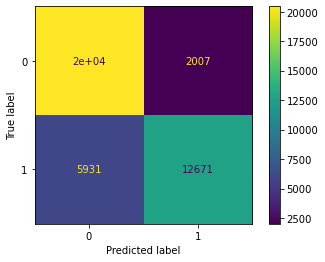

In [26]:
plot_confusion_matrix(xgb_pipe, X_train, y_train)

In [27]:
recall_score(xgb_y_preds, y_train)

0.8632647499659354

In [28]:
accuracy_score(xgb_y_preds, y_train)

0.8066872853907411

## A tuned XGB Classifier

In [108]:
xgb_pipe_tuned = Pipeline(steps =[('transform', CustomTransformer()),('scaler', StandardScaler()), 
                                  ('xgb', XGBClassifier(subsample=0.9,
                                                        reg_lambda=1.0,
                                                        n_estimators=120,
                                                        min_child_weight=1.0,
                                                        max_depth=15,
                                                        learning_rate=0.1,
                                                        gamma=1.0,
                                                        eta=0.9,
                                                        colsample_bytree=0.9,
                                                        colsample_bylevel=0.5))])

In [109]:
xgb_pipe_tuned.fit(X_train, y_train)

Pipeline(steps=[('transform', CustomTransformer()),
                ('scaler', StandardScaler()),
                ('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=0.5, colsample_bynode=1,
                               colsample_bytree=0.9, eta=0.9, gamma=1.0,
                               gpu_id=-1, importance_type='gain',
                               interaction_constraints='', learning_rate=0.1,
                               max_delta_step=0, max_depth=15,
                               min_child_weight=1.0, missing=nan,
                               monotone_constraints='()', n_estimators=120,
                               n_jobs=0, num_parallel_tree=1, random_state=0,
                               reg_alpha=0, reg_lambda=1.0, scale_pos_weight=1,
                               subsample=0.9, tree_method='exact',
                               validate_parameters=1, verbosity=None))])

In [110]:
y_train_preds = xgb_pipe_tuned.predict(X_train)

In [111]:
recall_score(y_train_preds, y_train)

0.870530771735591

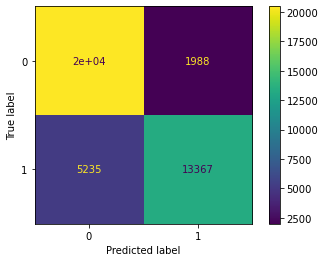

In [112]:
plot_confusion_matrix(xgb_pipe_tuned, X_train, y_train);

In [113]:
accuracy_score(y_train_preds, y_train)

0.8240995543433262

In [114]:
recall_score(y_train_preds, y_train)

0.870530771735591

In [134]:
y_score = xgb_pipe_tuned.predict_proba(X_train)

In [139]:
y_score[:,1]

array([0.03427773, 0.85646045, 0.7794526 , ..., 0.9518264 , 0.2201777 ,
       0.1282252 ], dtype=float32)

In [140]:
fpr, tpr, thresholds = roc_curve(y_train, y_score[:,1])

AUC: 0.9034938355513221


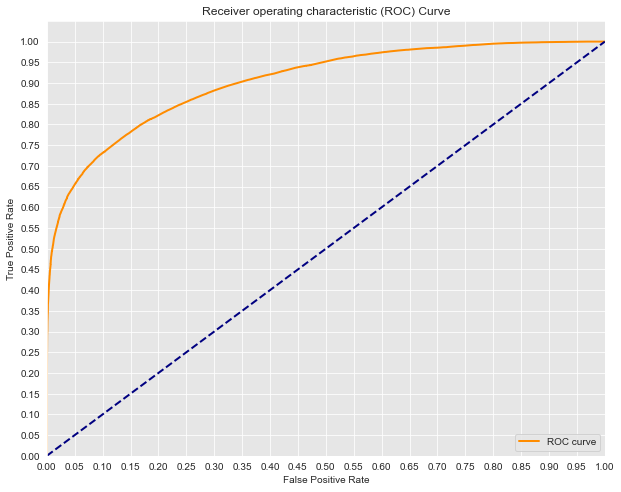

In [141]:
# Seaborn's beautiful styling
sns.set_style('darkgrid', {'axes.facecolor': '0.9'})

print('AUC: {}'.format(auc(fpr, tpr)))
plt.figure(figsize=(10, 8))
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()